Throughout these tasks, I'll use scanpy as it the Python library I am familiar with for scRNA analysis-related tasks. I'll import a bunch of other libraries for plotting and manipulating the data as needed.

In [64]:
import scanpy  as sc
import pandas  as pd
import numpy   as np
import seaborn as sea
import anndata as ad

# Loading the files into python objects
prot_filepath, rna_filepath = "protein_counts.csv", "rna_counts.csv"
prot_data, rna_data = sc.read_csv(prot_filepath) ,sc.read_csv(rna_filepath)



/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


<br>
I'll first detect mitochondrial genes in the scRNA dataset. Those are typically prefixed with MT-, so I'm just generating an extra boolean column for the genes based on the presence of the prefix in the name.

In [2]:
rna_data.var['mt'] = rna_data.var.index.str.startswith('MT')

<br>
Scanpy offers some quality checks, so just running those, including a calculation of MT-labeled genes

In [3]:
sc.pp.calculate_qc_metrics(rna_data, qc_vars=['mt'],log1p=False,percent_top=None,inplace=True)

<br>
Violin plots — very helpful to detect the population-wide distiribution of QC metrics.

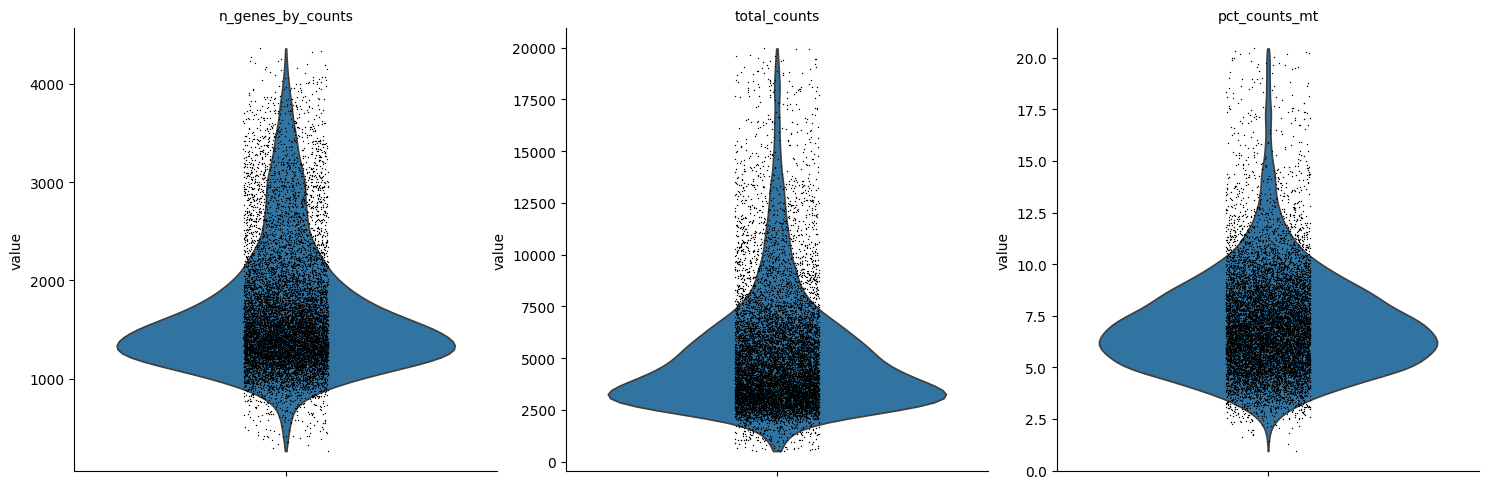

In [4]:
sc.pl.violin(rna_data,['n_genes_by_counts','total_counts','pct_counts_mt'],multi_panel=True)

<br>
We see that the <i>n_genes_by_counts</i> distribution is almost bimodal — most cells showed reads from ~1500 reads, and there's a second, much lower peak at around ~3000. This hints at double reads, so we should make sure to exclude them.
Similarly, in the <i>pct_counts_mt</i> plot, for cells with >12.5% there are some visible irregularities in the distirbution. Those should be filtered out too.
Here, I use median error as basis for filtering. I am exlcuding all those cells which showed more than 2.5x the
median abs error vs. the population-wide median.


In [5]:
# Compute the median and the median abs error
med_genes = np.median(rna_data.obs['n_genes_by_counts'])
med_dev   = np.median( np.abs(med_genes-rna_data.obs['n_genes_by_counts']) )

# Get the thresholds: twice the median abs error in either direction
max_genes = med_genes+2.5*med_dev
min_genes = med_genes-2.5*med_dev

# Filter the cells using those thresholds
sc.pp.filter_cells(rna_data,max_genes=max_genes,inplace=True)
sc.pp.filter_cells(rna_data,min_genes=min_genes,inplace=True)


/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


<br> 
Take a look at violin plots again, for changes

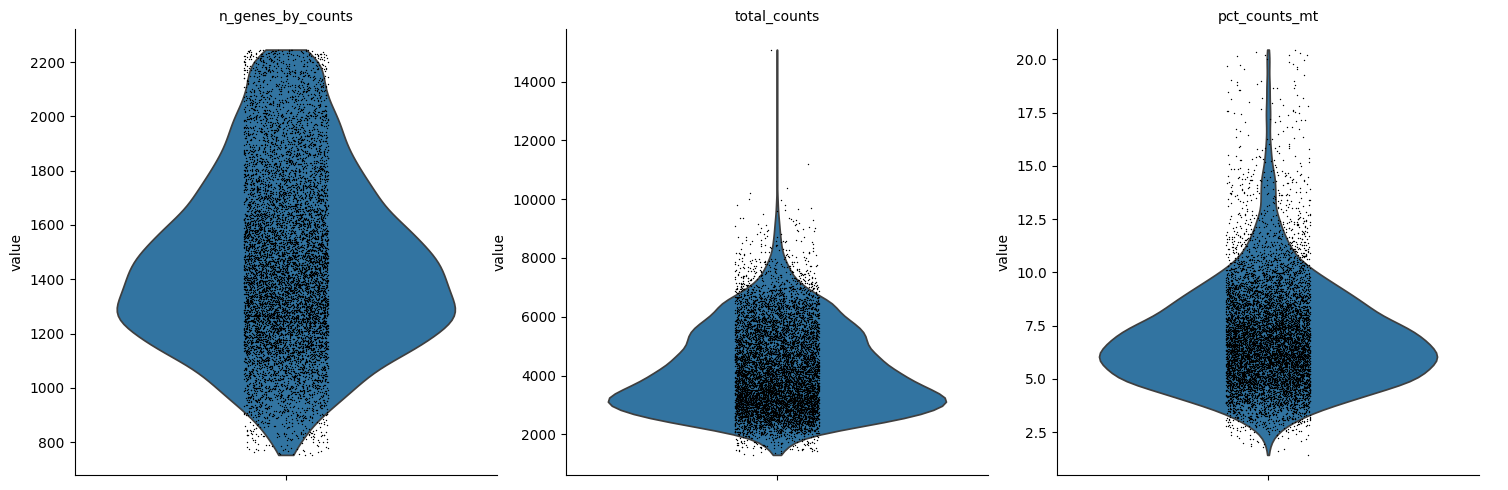

In [6]:
sc.pl.violin(rna_data,['n_genes_by_counts','total_counts','pct_counts_mt'],multi_panel=True)

<br>
There is a strange outlier at 15000 in the <i>total_counts</i> plot that's more very removed from the 
rest of the distribution. I'll filter <i>total_counts</i> too to get rid of these irregularities.

In [7]:
# Compute the median and the median error
med_counts = np.median(rna_data.obs['total_counts'])
med_dev   = np.median( np.abs(med_counts-rna_data.obs['total_counts']) )

# Get the thresholds: twice the median abs error in eother direction
max_counts = med_counts+2.5*med_dev
min_counts = med_counts-2.5*med_dev

# Filter the cells using those thresholds
sc.pp.filter_cells(rna_data,max_counts=max_counts,inplace=True)
sc.pp.filter_cells(rna_data,min_counts=min_counts,inplace=True)


/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


<br> 
Take a look at violin plots again, for changes

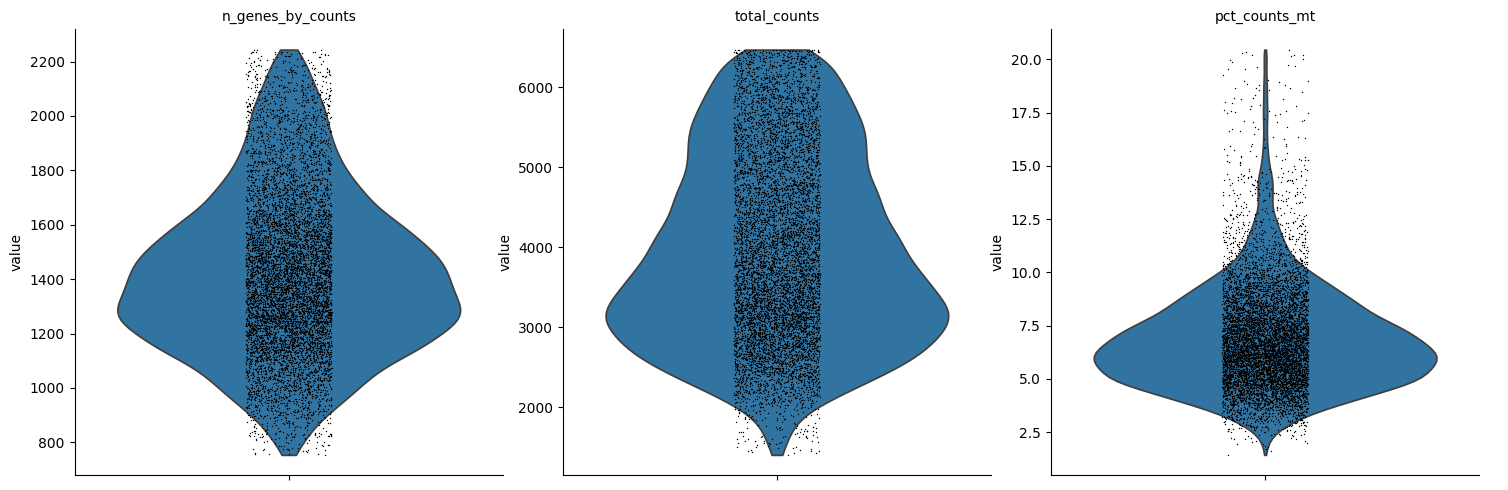

In [8]:
sc.pl.violin(rna_data,['n_genes_by_counts','total_counts','pct_counts_mt'],multi_panel=True)

<br>
Similarly, I am here filtering cells based on the increased percentage of mitochondrial genes, indicative of
cyoplasmic RNA under-capturing. Because I want to control only for mitochondrial over-representation, only a top threshold is set, at 2.5x abs median error. 

In [9]:
# Compute the abs median error
med_mt  = np.median(rna_data.obs['pct_counts_mt'])
med_dev = np.median( np.abs(med_mt-rna_data.obs['pct_counts_mt']) )

# Set the threshold
max_mt = med_mt+2.5*med_dev

# Filter the cells
rna_data.obs['mt_filter'] = rna_data.obs['pct_counts_mt']<max_mt
rna_data = rna_data[rna_data.obs['mt_filter'],:]

<br> 
Take a look at violin plots again, for changes

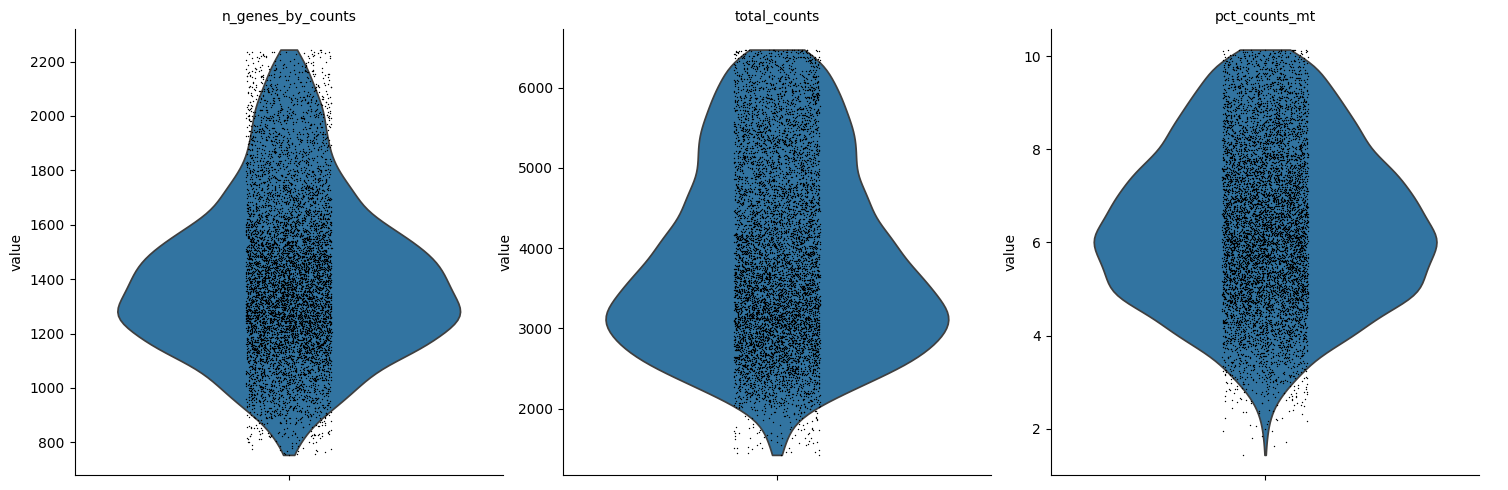

In [10]:
sc.pl.violin(rna_data,['n_genes_by_counts','total_counts','pct_counts_mt'],multi_panel=True)

<br> 
This just some pre-processing routines: normalize the cellular counts to 10,000, transforming them according to x -> log(x+1), then scaling to a standard notmal distirbution (for downstream use in PCA)/

In [11]:
# Normalize

sc.pp.normalize_total(rna_data,target_sum=1e4)

# Log-transform and standardize
sc.pp.log1p(rna_data)

/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


<br>
This part is optional to run now, hence commented out. It standardizes the data, applies PCA on the current dataset selecting top 75 components, then uses those to run UMAP. 

In [12]:
#sc.pp.scale(rna_data)
#sc.tl.pca(rna_data, svd_solver='auto', n_comps=75)
#sc.pp.neighbors(rna_data, n_pcs = 75)
#sc.tl.umap(rna_data)
#sc.pl.umap(rna_data)

<br>
Run quality check metrics on the protein data

In [65]:
sc.pp.calculate_qc_metrics(prot_data,log1p=False,percent_top=None,inplace=True)

<br>
Violin plot with the results

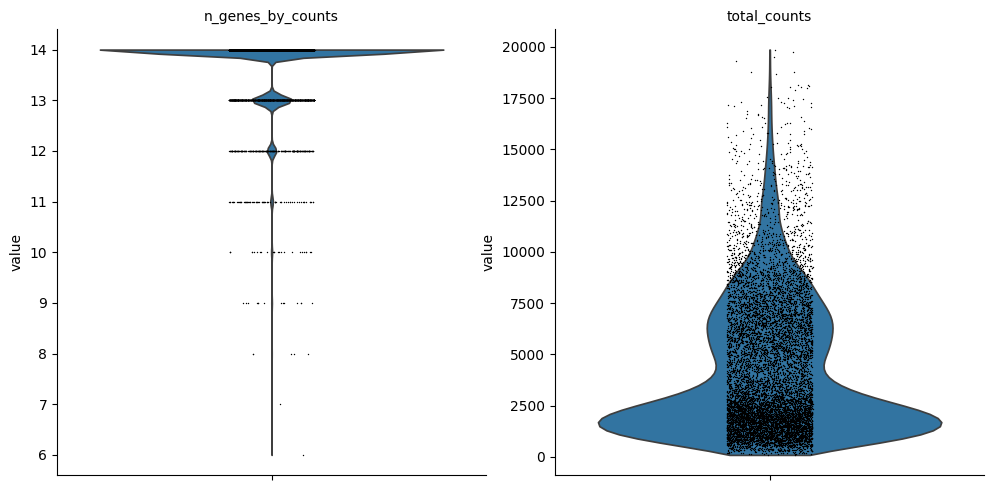

In [66]:
sc.pl.violin(prot_data,['n_genes_by_counts','total_counts'],multi_panel=True)

<br>
Produce a log-histogram plot for protein counts. Note that the transform applied here is log(x+1), to avoid issues with 0-detection. The line below shows an example for CD19, but I've done this for all. I'm using log1p because (a) the histograms are lot more consistent, (b) protein expression is lognormal anyway.

<Axes: ylabel='Count'>

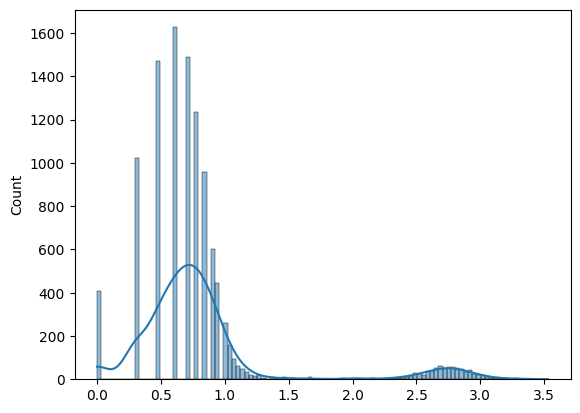

In [67]:
prot_counts = prot_data.X[:,7]
sea.histplot(np.log10(prot_counts+1), kde=True)

<br>
Adjust protein counts — if a cell has protein counts below a certain threshold, set that protein's
count to 0. The threshold is half-std below the mean. The goal is to get rid of the spurious low-expression peaks in teh histogram.

In [68]:
for idx in range(prot_data.X.shape[1]):
    prot_counts = prot_data.X[:,idx] # Get the counts
    log1p_counts = np.log10(prot_counts+1) # log1n transform
    prot_mean = np.mean(log1p_counts)
    prot_std  = np.std(log1p_counts)
    thresh = prot_mean - 0.5*prot_std # Get the threshold based on the mean and std of log1p data 
    prot_data.X[:,idx] = prot_data.X[:,idx]*(log1p_counts>thresh) # Apply the mask


    

<br>
Produce a violin plot with the results

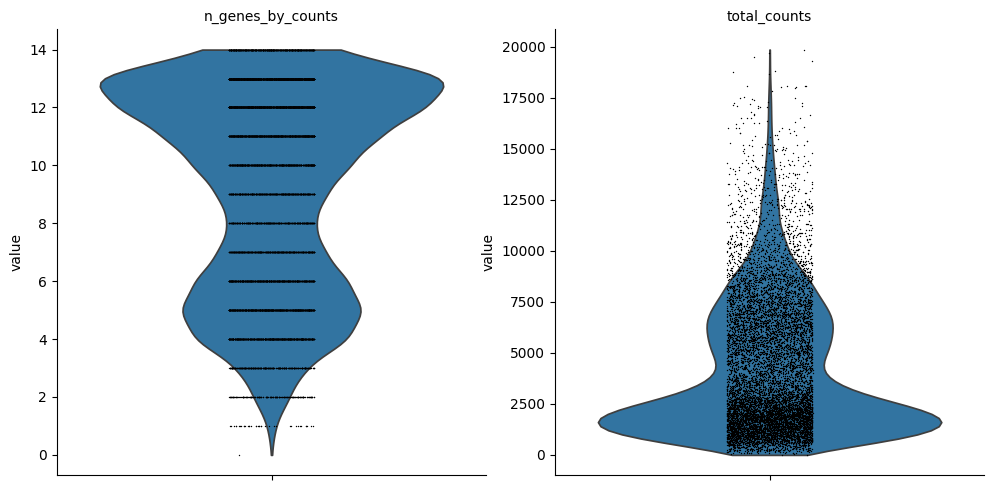

In [17]:
sc.pp.calculate_qc_metrics(prot_data,log1p=False,percent_top=None,inplace=True)
sc.pl.violin(prot_data,['n_genes_by_counts','total_counts'],multi_panel=True)

<br>
This part is optional to run now, hence commented out. It standardizes the data, applies PCA on the current protein dataset selecting top 14 (ie., all) components, then uses those to run UMAP. 

/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/User

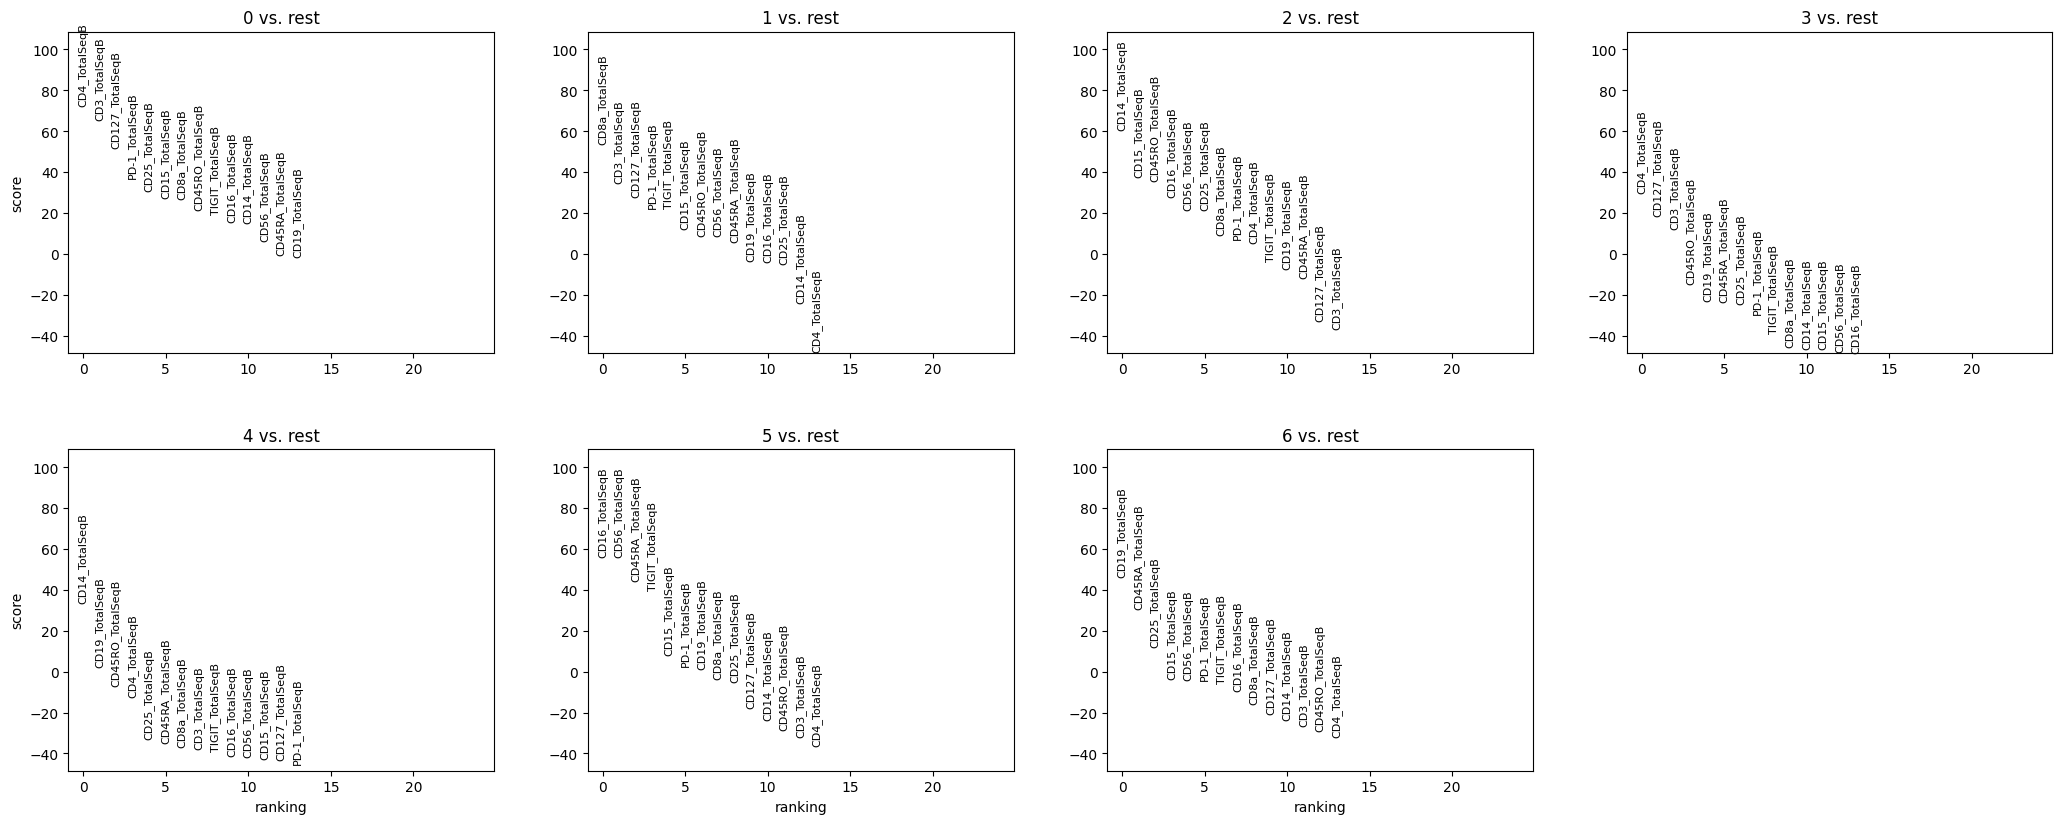

In [73]:
# sc.pp.scale(prot_data)
# sc.tl.pca(prot_data, svd_solver='auto', n_comps=14)
# sc.pp.neighbors(prot_data, n_pcs = 10, n_neighbors=100)

# sc.tl.umap(prot_data,min_dist=0.3)

# sc.tl.leiden(prot_data,resolution=0.1)
# sc.pl.umap(prot_data,color='leiden')

# sc.tl.rank_genes_groups(prot_data, groupby='leiden', method='wilcoxon')
# sc.pl.rank_genes_groups(prot_data, n_genes=25)



<br>
I am merging the two datasets here. Some indices were non unique interfering with the inner join, so I had to append a suffix to make them unqiue.

In [18]:
# Merging via an inner join operation

rna_data.obs_names_make_unique(join='_')
prot_data.obs_names_make_unique(join='_')
all_data = ad.concat([rna_data, prot_data], join="inner", axis=1)


<br>
Running PCA to reduce the set to 100 dimensions (I picked some options, this seemed to work best), and running UMAP. Last, I do Leiden clustering. Hyperparameters are as everywhere else result of some trial-and-error, but I saw fairly consistent results.

/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


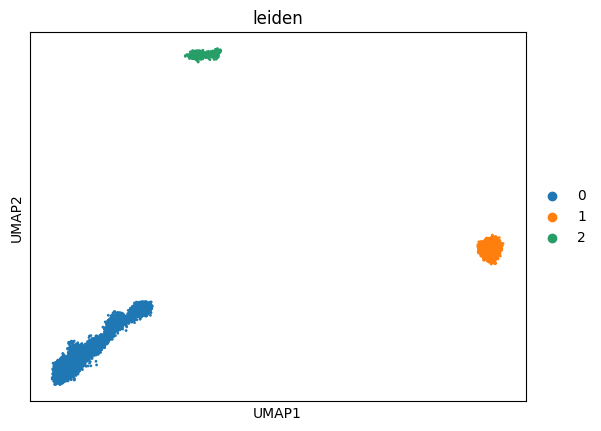

In [59]:
# Dimensionality reduction block
sc.pp.scale(all_data)
sc.tl.pca(all_data, svd_solver='auto', n_comps=100)
sc.pp.neighbors(all_data, n_pcs = 100)
sc.tl.umap(all_data,min_dist=0.3,n_components=3)

# Cluster and plot
sc.tl.leiden(all_data,resolution=0.1)
sc.pl.umap(all_data,color='leiden')

<br>
Judging by the protein names, I could guess these are blood cells, and based on the description you gave me, this is CITE-seq data (or equivalent). There are five clusters, with the most siginificant RNA/proteins shown for each below.

/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


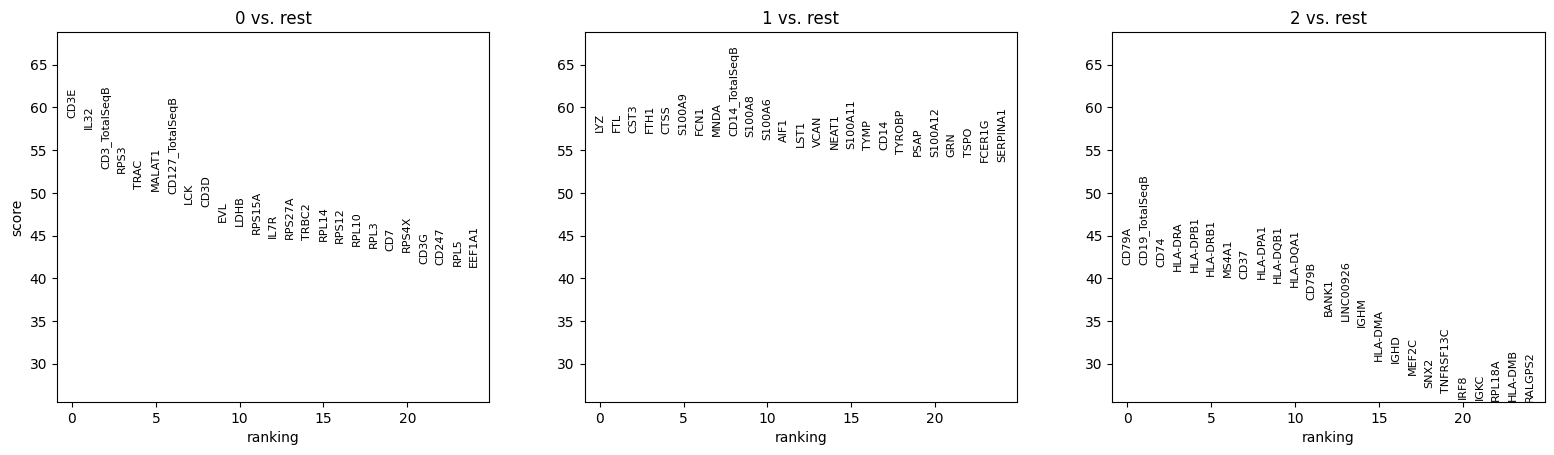

In [57]:
sc.tl.rank_genes_groups(all_data, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(all_data, n_genes=25)



<br>
To understand the biological meaning of clusters, I looked at the genes/proteins to see which one corresponds to specific expression patterns. Since some of the algorithms are stochastic, your rerun from scratch might not produce the same arbitrary ordering of plots as I have, and UMAP components can flip signs (direction X is the same as direction -X for UMAP purposes). Finally, the way scanpy colors clusters might not be consistent, but I'll try to be as descriptive as possible.

<br><br>
<br>
One cluster (#0, blue) with elevated CD3 corresponds to T cells.
<br>
Another cluster (#1, orange) shows some non-tissue specific genes, e.g., lyzozyme, ferritin. CD14, however, is macrophage specific, MNDA is a marker of monocyte lineage, so this cluster is monocytes (which turn into macrophages peripherally).
<br>
Next cluster (#3, red) with elevated CD56 and NKG corresponds to Natural Killers.
<br>
Finally cluster (#4, purple in my runs) shows significant abundance of CD79A and CD19. Those are B-cell markers.

<br>
The last cluster (#2,green) shows elevated expression of ribosomal genes. Ideally, I would exclude cells which show elevated ribosomal expression, same what I did with mitochondiral genes, but I couldn't find a reliable ribosomal gene name dataset. I looked at the top 50 most different genes, but couldn't find anything specific about this cluster. I really wonder what this is — maybe erythrocytes? That would explain the overabundance of ribosomal and mitochondrial genes, after all they don't have a nucleus to make new mRNA. Or hematopoetic stem cells? That would explain the lack of differentiation and the high protein synthesis rates.

<br>
Epilogue

<br>
Though I think I answered the questions you posed in the email, wouldn't hurt to state them here.
<br>
1. Quality checks were done and are explained in context. <br>
2. I appended protein data to RNA data for each cell, standardized them, ran PCA, and then used most variable components to run UMAP. That's my low-dim embedding. <br>
3. UMAP was used to construct clusters by the Leiden algorithm. <br>
4. I didn't get the chance to implement batch-effect correction due to time constraints, but I can still give an overview of how I'd do it. Scanpy has a method .pp.regress_out(). I'd scan the datasets to see which cell comes from which batch, add a column corresponding to that, then use sc.pp.regress_out() to eliminate batch effects. <br>
5. By cluster enrichment, I was able to accurately identify 4 of the 5 clusters. For the last one, I suspect either erythrocytes or hematopoetic stem cells (leaning towards the latter). <br>